# 04_calendar_trend.ipynb
日历图、TrendLevel、TimeVariation 动态可视化

---

## 1. 导入

```python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calmap
import seaborn as sns

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
df = pd.read_csv('../data/processed/china_50_cities.csv', parse_dates=['Datetime'])
df.head()

df = pd.read_csv('../data/processed/china_50_cities.csv', parse_dates=['Datetime'])
pollutant = 'CO(GT)'

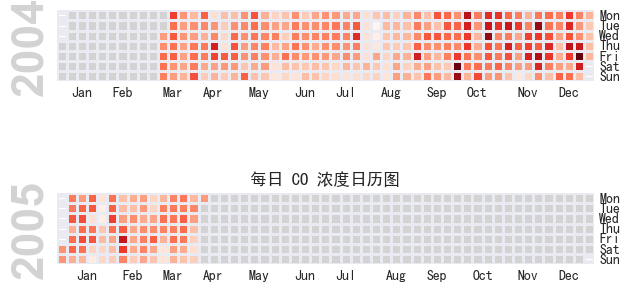

In [2]:
#日历图
daily = df.set_index('Datetime')[pollutant].resample('D').mean()
calmap.calendarplot(daily, cmap='Reds', fillcolor='lightgrey')
plt.title('每日 CO 浓度日历图')
plt.show()


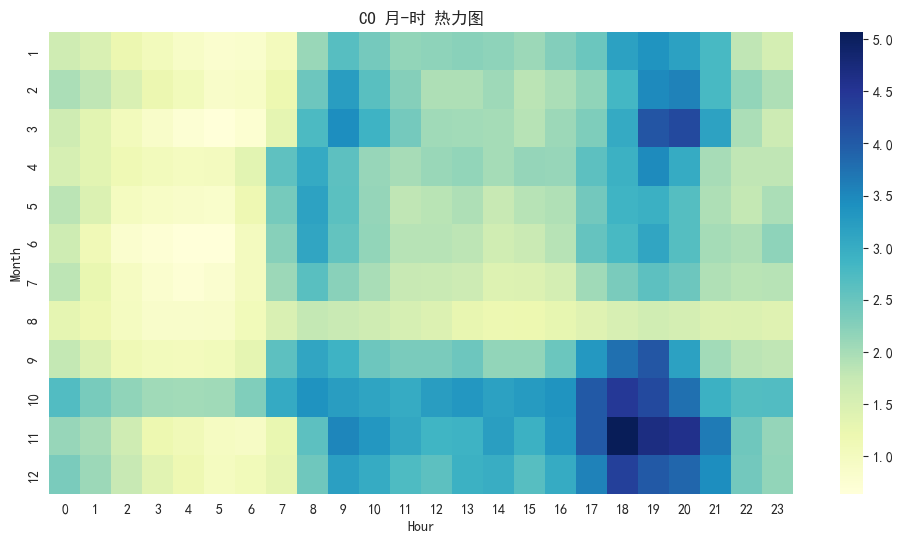

In [3]:
#TrendLevel Heatmap (月×小时)
pivot = df.pivot_table(values=pollutant, index=df['Datetime'].dt.month, columns=df['Datetime'].dt.hour, aggfunc='mean')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('CO 月-时 热力图')
plt.xlabel('Hour')
plt.ylabel('Month')
plt.show()


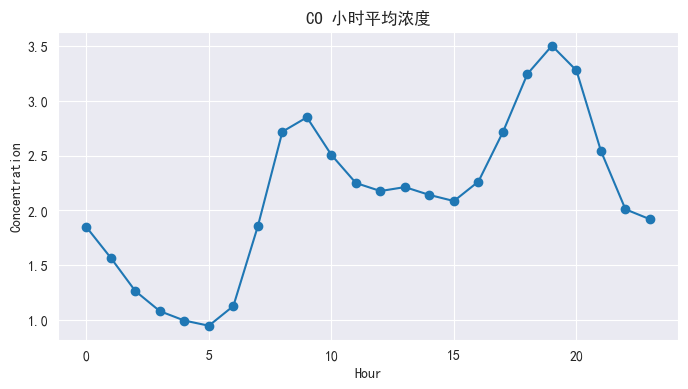

In [4]:
#Time Variation 折线
hourly = df.groupby(df['Datetime'].dt.hour)[pollutant].mean()
plt.figure(figsize=(8,4))
hourly.plot(marker='o')
plt.title('CO 小时平均浓度')
plt.xlabel('Hour')
plt.ylabel('Concentration')
plt.show()




In [5]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

# 强制使用 Orca 渲染导出图像
pio.kaleido.scope.default_format = None  # 禁用 kaleido，避免误用
pio.renderers.default = 'browser'  # 显示图表时在默认浏览器中打开

# 加载数据
df = pd.read_csv('../data/processed/china_50_cities.csv', parse_dates=['Datetime'])

# ==== 参数设定 ====
pollutant = 'CO(GT)'
polls = ['CO(GT)', 'NO2(GT)', 'C6H6(GT)', 'NMHC(GT)']

# 显示名称映射
label_map = {
    'CO(GT)': 'CO',
    'NO2(GT)': 'NO2',
    'C6H6(GT)': 'C6H6',
    'NMHC(GT)': 'NMHC'
}
display_name = label_map.get(pollutant, pollutant)

# 设置时间索引
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

# 滑动窗口平均
df['rolling_avg'] = df[pollutant].rolling(window=7 * 24).mean()

# 月趋势
monthly = df[pollutant].resample('ME').mean()
# 小时趋势
hourly = df[pollutant].groupby(df.index.hour).mean()

# 简化 AQI 等级映射
def classify_aqi(co):
    if pd.isna(co):
        return 'Unknown'
    elif co <= 1:
        return 'Good'
    elif co <= 2:
        return 'Moderate'
    elif co <= 10:
        return 'Unhealthy'
    else:
        return 'Hazardous'

df['AQI_Level'] = df[pollutant].apply(classify_aqi)

# 创建子图
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        f'Monthly Trend of {display_name}',
        f'Hourly Trend of {display_name}',
        f'{display_name} Distribution (Box)',
        'Correlation Heatmap',
        f'7-Day Moving Avg of {display_name}',
        f'{display_name} by Station'
    )
)

# 月趋势
fig.add_trace(
    go.Scatter(x=monthly.index, y=monthly.values, name='Monthly Avg'),
    row=1, col=1
)

# 小时趋势
fig.add_trace(
    go.Bar(x=hourly.index, y=hourly.values, name='Hourly Avg'),
    row=1, col=2
)

# 箱线图
fig.add_trace(
    go.Box(y=df[pollutant].dropna(), name='Boxplot'),
    row=2, col=1
)

# 热力图
corr = df[polls].corr()
fig.add_trace(
    go.Heatmap(
        z=corr.values,
        x=[label_map.get(c, c) for c in polls],
        y=[label_map.get(c, c) for c in polls],
        colorscale='Viridis', zmin=-1, zmax=1
    ),
    row=2, col=2
)

# 滑动平均线
fig.add_trace(
    go.Scatter(x=df.index, y=df['rolling_avg'], name='7-day MA', line=dict(color='orange')),
    row=3, col=1
)

# Station 分组箱线图
if 'Station' in df.columns:
    for s in df['Station'].unique():
        fig.add_trace(
            go.Box(
                y=df[df['Station'] == s][pollutant],
                name=s
            ),
            row=3, col=2
        )

# 布局
fig.update_layout(
    height=1000,
    width=1100,
    title_text=f"{display_name} Analysis Summary (with AQI & Station)",
    showlegend=False
)

# 显示图表（在浏览器中）
fig.show()

# ✅ 使用 Orca 导出为 PNG（或 PDF）
# 请确保 Orca 安装成功且在 PATH 环境变量中
try:
    fig.write_image("output_orca_plot1.png", engine="orca")  # 可换成 .pdf
    print("✅ 图像已使用 Orca 成功导出为 output_orca_plot1.png")
except Exception as e:
    print("❌ Orca 导出失败：", e)


✅ 图像已使用 Orca 成功导出为 output_orca_plot1.png
